In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import unicodedata
import random
import seaborn as sns
import tensorflow as tf
import json
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from openTSNE import TSNE
from pprint import pprint
from sklearn.decomposition import PCA
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from scipy.spatial.distance import cosine
from sklearn.preprocessing import LabelEncoder

In [2]:
def normalize_and_clean_files(directory, prefix):
    all_files = os.listdir(directory)
    cleaned_files = [
        unicodedata.normalize('NFC', f.strip())
        .replace('\u200c', '')
        .replace('\u200e', '')
        .replace('\ufeff', '')
        for f in all_files
    ]
    filtered_files = [f for f in cleaned_files if f.startswith(prefix) and ".tfrecord" in f]
    return filtered_files

In [3]:
train_dir = "C:/DatascienceProject/dataset_cars/train"
test_dir = "C:/DatascienceProject/dataset_cars/test"

clean_train_files = normalize_and_clean_files(train_dir, "cars196-train.tfrecord")
clean_test_files = normalize_and_clean_files(test_dir, "cars196-test.tfrecord")

In [4]:
print("Train files:", clean_train_files)
print("Test files:", clean_test_files)

Train files: ['cars196-train.tfrecord-00000-of-00008', 'cars196-train.tfrecord-00001-of-00008', 'cars196-train.tfrecord-00002-of-00008', 'cars196-train.tfrecord-00003-of-00008', 'cars196-train.tfrecord-00004-of-00008', 'cars196-train.tfrecord-00005-of-00008', 'cars196-train.tfrecord-00006-of-00008', 'cars196-train.tfrecord-00007-of-00008']
Test files: ['cars196-test.tfrecord-00000-of-00008', 'cars196-test.tfrecord-00001-of-00008', 'cars196-test.tfrecord-00002-of-00008', 'cars196-test.tfrecord-00003-of-00008', 'cars196-test.tfrecord-00004-of-00008', 'cars196-test.tfrecord-00005-of-00008', 'cars196-test.tfrecord-00006-of-00008', 'cars196-test.tfrecord-00007-of-00008']


In [5]:
def parse_tfrecord(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    return tf.io.parse_single_example(example_proto, feature_description)

def load_tfrecord_dataset(directory, cleaned_files):
    dataset = tf.data.TFRecordDataset([os.path.join(directory, file) for file in cleaned_files])
    return dataset.map(parse_tfrecord)

train_dataset = load_tfrecord_dataset(train_dir, clean_train_files)
test_dataset = load_tfrecord_dataset(test_dir, clean_test_files)

print("Train dataset loaded")
print("Test dataset loaded")

Train dataset loaded
Test dataset loaded


In [6]:
json_path = "C:/DatascienceProject/dataset_cars/dataset_info.json"

with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

print(json.dumps(data, indent=4))

{
    "citation": "@inproceedings{KrauseStarkDengFei-Fei_3DRR2013,\ntitle = {3D Object Representations for Fine-Grained Categorization},\nbooktitle = {4th International IEEE Workshop on  3D Representation and Recognition (3dRR-13)},\nyear = {2013},\naddress = {Sydney, Australia},\nauthor = {Jonathan Krause and Michael Stark and Jia Deng and Li Fei-Fei}\n}",
    "description": "The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.",
    "downloadSize": "1957136468",
    "location": {
        "urls": [
            "https://ai.stanford.edu/~jkrause/cars/car_dataset.html"
        ]
    },
    "name": "cars196",
    "schema": {
        "feature": [
            {
                "name": "bbox",
                "shape": {
                    "dim": [
    

In [7]:
print(f"Train files: {clean_train_files}")
print(f"Test files: {clean_test_files}")

for file in clean_train_files[:3]:    
    file_path = os.path.join(train_dir, file)
    try:
        dataset = tf.data.TFRecordDataset(file_path)
        for record in dataset.take(1):  
            print(f"Successfully read from {file_path}")
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")

Train files: ['cars196-train.tfrecord-00000-of-00008', 'cars196-train.tfrecord-00001-of-00008', 'cars196-train.tfrecord-00002-of-00008', 'cars196-train.tfrecord-00003-of-00008', 'cars196-train.tfrecord-00004-of-00008', 'cars196-train.tfrecord-00005-of-00008', 'cars196-train.tfrecord-00006-of-00008', 'cars196-train.tfrecord-00007-of-00008']
Test files: ['cars196-test.tfrecord-00000-of-00008', 'cars196-test.tfrecord-00001-of-00008', 'cars196-test.tfrecord-00002-of-00008', 'cars196-test.tfrecord-00003-of-00008', 'cars196-test.tfrecord-00004-of-00008', 'cars196-test.tfrecord-00005-of-00008', 'cars196-test.tfrecord-00006-of-00008', 'cars196-test.tfrecord-00007-of-00008']
Successfully read from C:/DatascienceProject/dataset_cars/train\cars196-train.tfrecord-00000-of-00008
Successfully read from C:/DatascienceProject/dataset_cars/train\cars196-train.tfrecord-00001-of-00008
Successfully read from C:/DatascienceProject/dataset_cars/train\cars196-train.tfrecord-00002-of-00008


In [8]:
for raw_record in train_dataset.take(3):
    print("Parsed Record:")
    for key, value in raw_record.items():
        print(f"{key}: {value}")

Parsed Record:
image: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x02\x00\x1c\x00\x1c\x00\x00\xff\xe2\x19\xfcICC_PROFILE\x00\x01\x01\x00\x00\x19\xecappl\x02\x10\x00\x00mntrRGB XYZ \x07\xda\x00\x06\x00\x17\x00\x14\x00\x0c\x00,acspAPPL\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-appl\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x11desc\x00\x00\x01P\x00\x00\x00bdscm\x00\x00\x01\xb4\x00\x00\x02Bcprt\x00\x00\x03\xf8\x00\x00\x00\xd0wtpt\x00\x00\x04\xc8\x00\x00\x00\x14rXYZ\x00\x00\x04\xdc\x00\x00\x00\x14gXYZ\x00\x00\x04\xf0\x00\x00\x00\x14bXYZ\x00\x00\x05\x04\x00\x00\x00\x14rTRC\x00\x00\x05\x18\x00\x00\x08\x0caarg\x00\x00\r$\x00\x00\x00 vcgt\x00\x00\rD\x00\x00\x06\x12ndin\x00\x00\x13X\x00\x00\x06>chad\x00\x00\x19\x98\x00\x00\x00,mmod\x00\x00\x19\xc4\x00\x00\x

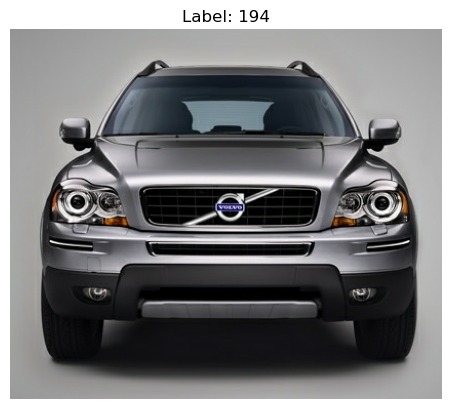

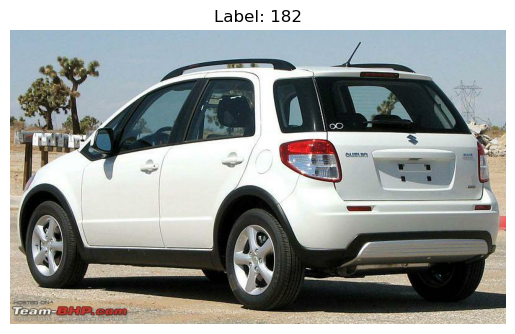

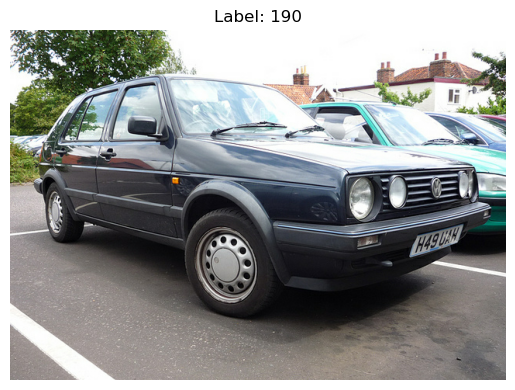

In [9]:
for raw_record in train_dataset.take(3):
    image = tf.io.decode_jpeg(raw_record['image'].numpy())
    label = raw_record['label'].numpy()

    plt.figure()
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

In [10]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D()
])

model.trainable = False

In [11]:
def preprocess_image(image_bytes):
    image = tf.image.decode_jpeg(image_bytes, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = preprocess_input(image)
    return image

In [12]:
def generate_embeddings(dataset):
    embeddings = []
    labels = []

    for raw_record in dataset:
        image = preprocess_image(raw_record['image'].numpy())
        label = raw_record['label'].numpy()
        
        image = tf.expand_dims(image, axis=0)   
        embedding = model(image, training=False).numpy()[0]

        embeddings.append(embedding)
        labels.append(label)

    return np.array(embeddings), np.array(labels)

In [13]:
train_dataset_subset = train_dataset.take(250)
test_dataset_subset = test_dataset.take(250)

train_embeddings, train_labels = generate_embeddings(train_dataset_subset)
test_embeddings, test_labels = generate_embeddings(test_dataset_subset)

In [14]:
np.save("train_embeddings_250.npy", train_embeddings)
np.save("test_embeddings_250.npy", test_embeddings)
np.save("train_labels_250.npy", train_labels)
np.save("test_labels_250.npy", test_labels)

In [15]:
cosine_sim_train = cosine_similarity(train_embeddings)

cosine_sim_test = cosine_similarity(test_embeddings)

print("Cosine similarity (Train):", cosine_sim_train.shape)
print("Cosine similarity (Test):", cosine_sim_test.shape)

Cosine similarity (Train): (250, 250)
Cosine similarity (Test): (250, 250)


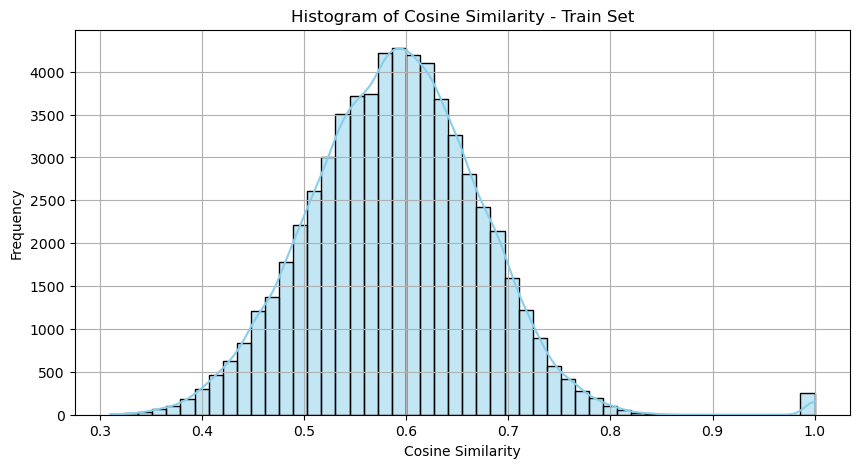

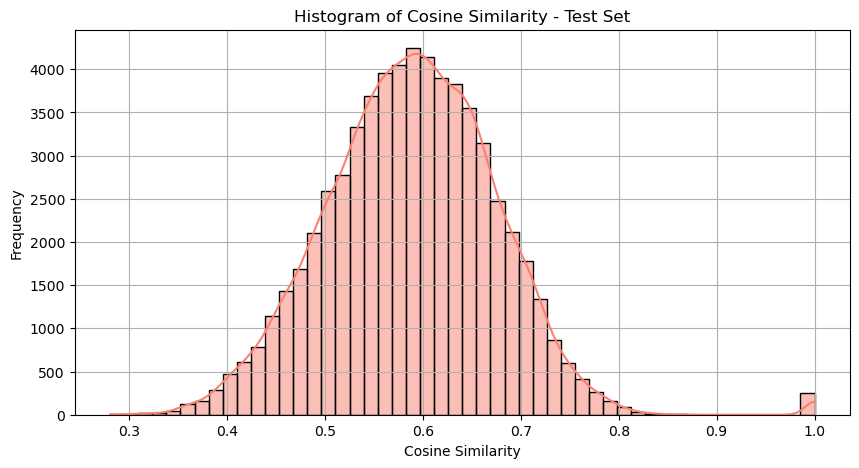

In [17]:
import seaborn as sns

cosine_sim_train = cosine_similarity(train_embeddings)
cosine_sim_test = cosine_similarity(test_embeddings)

np.save("cosine_sim_train.npy", cosine_sim_train)
np.save("cosine_sim_test.npy", cosine_sim_test)

plt.figure(figsize=(10, 5))
sns.histplot(cosine_sim_train.flatten(), bins=50, kde=True, color='skyblue')
plt.title("Histogram of Cosine Similarity - Train Set")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(cosine_sim_test.flatten(), bins=50, kde=True, color='salmon')
plt.title("Histogram of Cosine Similarity - Test Set")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [18]:
def find_top_k_similarities(sim_matrix, labels, k=5, most_similar=True):
    results = []
    size = sim_matrix.shape[0]
    sim_matrix_copy = sim_matrix.copy()

    np.fill_diagonal(sim_matrix_copy, -np.inf if most_similar else np.inf)

    for _ in range(k):
        if most_similar:
            idx = np.unravel_index(np.argmax(sim_matrix_copy), sim_matrix_copy.shape)
        else:
            idx = np.unravel_index(np.argmin(sim_matrix_copy), sim_matrix_copy.shape)

        i, j = idx
        sim = sim_matrix_copy[i, j]
        same_class = labels[i] == labels[j]

        results.append({
            "index_1": i,
            "index_2": j,
            "similarity": sim,
            "label_1": labels[i],
            "label_2": labels[j],
            "same_class": same_class
        })

        sim_matrix_copy[i, j] = -np.inf if most_similar else np.inf

    return results

In [19]:
most_similar_train = find_top_k_similarities(cosine_sim_train, train_labels, k=5, most_similar=True)
most_different_train = find_top_k_similarities(cosine_sim_train, train_labels, k=5, most_similar=False)

most_similar_test = find_top_k_similarities(cosine_sim_test, test_labels, k=5, most_similar=True)
most_different_test = find_top_k_similarities(cosine_sim_test, test_labels, k=5, most_similar=False)

In [20]:
from pprint import pprint

print("\nTop 5 most similar pairs (Train):")
pprint(most_similar_train)

print("\nTop 5 most different pairs (Train):")
pprint(most_different_train)

print("\nTop 5 most similar pairs (Test):")
pprint(most_similar_test)

print("\nTop 5 most different pairs (Test):")
pprint(most_different_test)


Top 5 most similar pairs (Train):
[{'index_1': 88,
  'index_2': 110,
  'label_1': 52,
  'label_2': 93,
  'same_class': False,
  'similarity': 0.8860025},
 {'index_1': 110,
  'index_2': 88,
  'label_1': 93,
  'label_2': 52,
  'same_class': False,
  'similarity': 0.8860025},
 {'index_1': 152,
  'index_2': 213,
  'label_1': 17,
  'label_2': 93,
  'same_class': False,
  'similarity': 0.8562417},
 {'index_1': 213,
  'index_2': 152,
  'label_1': 93,
  'label_2': 17,
  'same_class': False,
  'similarity': 0.8562417},
 {'index_1': 32,
  'index_2': 79,
  'label_1': 77,
  'label_2': 107,
  'same_class': False,
  'similarity': 0.84742785}]

Top 5 most different pairs (Train):
[{'index_1': 161,
  'index_2': 192,
  'label_1': 127,
  'label_2': 0,
  'same_class': False,
  'similarity': 0.30946437},
 {'index_1': 192,
  'index_2': 161,
  'label_1': 0,
  'label_2': 127,
  'same_class': False,
  'similarity': 0.30946437},
 {'index_1': 192,
  'index_2': 202,
  'label_1': 0,
  'label_2': 103,
  'same_cla

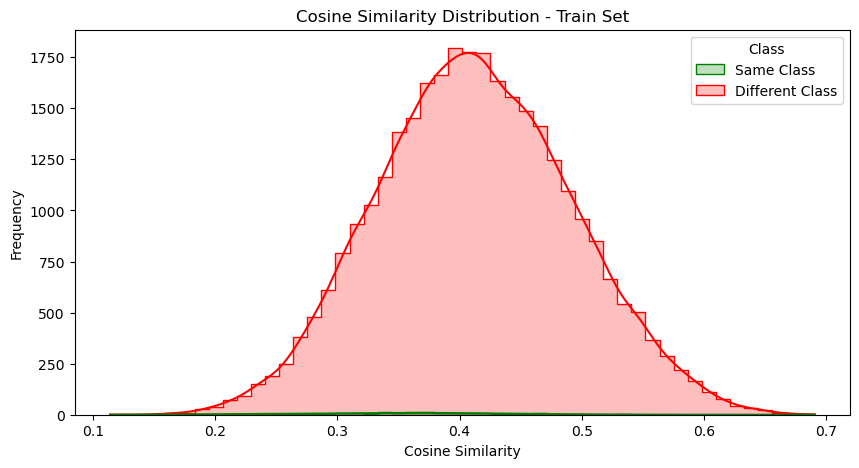

In [22]:
import pandas as pd
from itertools import combinations

def get_similarity_by_class(embeddings, labels):
    same_class_sims = []
    diff_class_sims = []

    for i, j in combinations(range(len(embeddings)), 2):
        sim = cosine(embeddings[i], embeddings[j])
        if labels[i] == labels[j]:
            same_class_sims.append(sim)
        else:
            diff_class_sims.append(sim)

    return same_class_sims, diff_class_sims

same_train, diff_train = get_similarity_by_class(train_embeddings, train_labels)

df_train = pd.DataFrame({
    "Similarity": same_train + diff_train,
    "Class": ["Same Class"] * len(same_train) + ["Different Class"] * len(diff_train)
})

plt.figure(figsize=(10, 5))
sns.histplot(data=df_train, x="Similarity", hue="Class", bins=50, kde=True, palette=["green", "red"], element="step")
plt.title("Cosine Similarity Distribution - Train Set")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

In [23]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_top1_accuracy(embeddings, labels):
    similarity_matrix = cosine_similarity(embeddings)
    np.fill_diagonal(similarity_matrix, -1)    

    most_similar_indices = np.argmax(similarity_matrix, axis=1)

    correct = labels[most_similar_indices] == labels
    accuracy = np.mean(correct)
    return accuracy

def compute_top5_accuracy(embeddings, labels):
    similarity_matrix = cosine_similarity(embeddings)
    np.fill_diagonal(similarity_matrix, -1)

    top5_indices = np.argsort(-similarity_matrix, axis=1)[:, :5]

    correct = [labels[i] in labels[top5_indices[i]] for i in range(len(labels))]
    accuracy = np.mean(correct)
    return accuracy

top1_train = compute_top1_accuracy(train_embeddings, train_labels)
top5_train = compute_top5_accuracy(train_embeddings, train_labels)

top1_test = compute_top1_accuracy(test_embeddings, test_labels)
top5_test = compute_top5_accuracy(test_embeddings, test_labels)

print(f"Top-1 Accuracy (Train): {top1_train:.2%}")
print(f"Top-5 Accuracy (Train): {top5_train:.2%}")
print(f"Top-1 Accuracy (Test): {top1_test:.2%}")
print(f"Top-5 Accuracy (Test): {top5_test:.2%}")

Top-1 Accuracy (Train): 4.40%
Top-5 Accuracy (Train): 15.20%
Top-1 Accuracy (Test): 9.20%
Top-5 Accuracy (Test): 21.20%


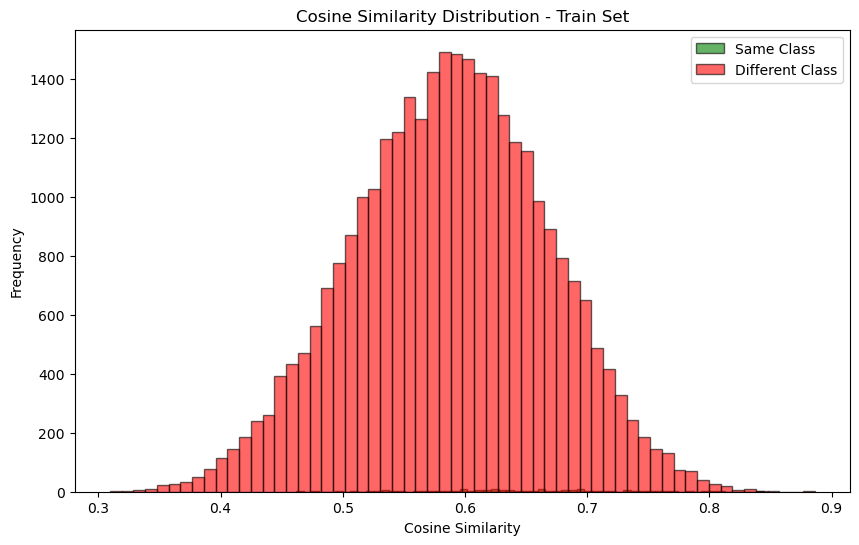

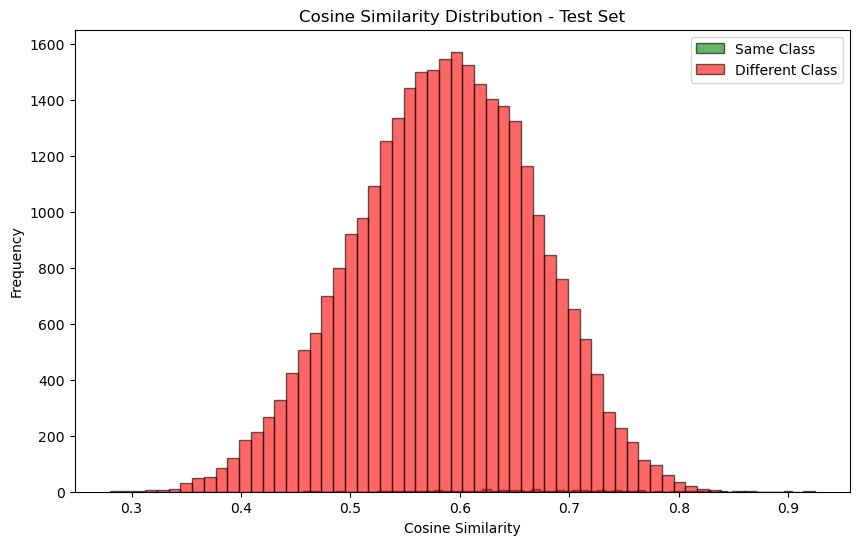

In [24]:
def plot_similarity_distribution(cosine_sim, labels, title):
    same_class = []
    diff_class = []

    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            sim = cosine_sim[i][j]
            if labels[i] == labels[j]:
                same_class.append(sim)
            else:
                diff_class.append(sim)

    plt.figure(figsize=(10, 6))
    plt.hist(same_class, bins=60, alpha=0.6, label='Same Class', color='green', edgecolor='black')
    plt.hist(diff_class, bins=60, alpha=0.6, label='Different Class', color='red', edgecolor='black')
    plt.title(f"Cosine Similarity Distribution - {title}")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

plot_similarity_distribution(cosine_sim_train, train_labels, "Train Set")

plot_similarity_distribution(cosine_sim_test, test_labels, "Test Set")

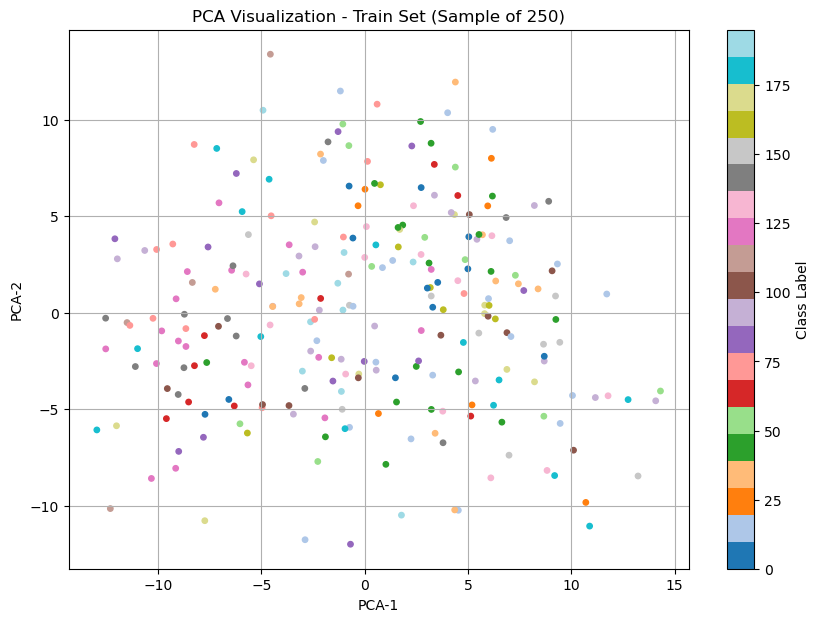

In [38]:
from sklearn.decomposition import PCA

sample_size = min(250, len(train_embeddings))
indices = np.random.choice(len(train_embeddings), sample_size, replace=False)
train_embeddings_sample = train_embeddings[indices]
train_labels_sample = train_labels[indices]

pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_embeddings_sample)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(train_pca[:, 0], train_pca[:, 1], c=train_labels_sample, cmap="tab20", s=15)
plt.colorbar(scatter, label='Class Label')
plt.title("PCA Visualization - Train Set (Sample of 250)")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.grid(True)
plt.show()

In [2]:
import numpy as np

train_embeddings = np.load("train_embeddings.npy")
test_embeddings = np.load("test_embeddings.npy")
train_labels = np.load("train_labels.npy")
test_labels = np.load("test_labels.npy")

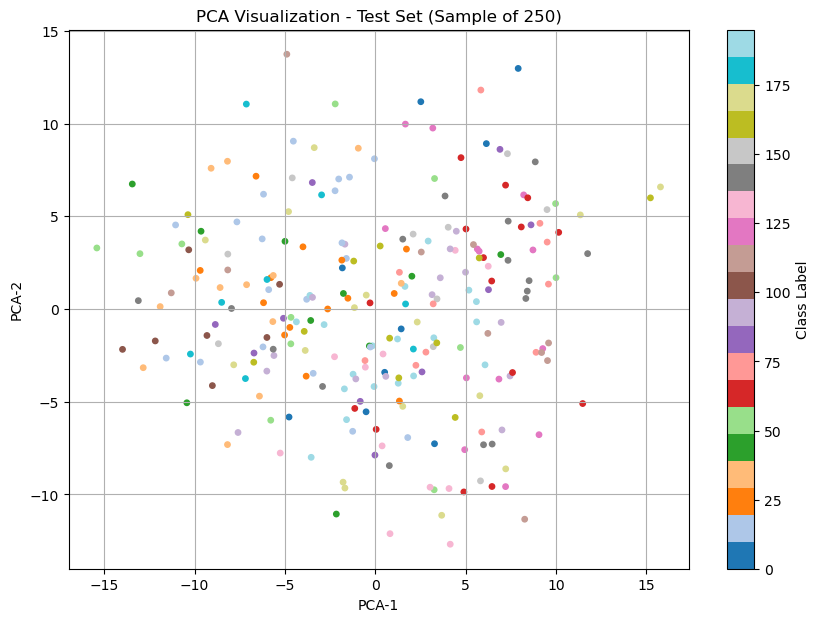

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

test_embeddings = np.load("test_embeddings.npy")
test_labels = np.load("test_labels.npy")

test_embeddings = test_embeddings.astype("float64")

sample_size = min(250, len(test_embeddings))
indices = np.random.choice(len(test_embeddings), sample_size, replace=False)
test_embeddings_sample = test_embeddings[indices]
test_labels_sample = test_labels[indices]

pca = PCA(n_components=2)
test_pca = pca.fit_transform(test_embeddings_sample)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(test_pca[:, 0], test_pca[:, 1], c=test_labels_sample, cmap="tab20", s=15)
plt.colorbar(scatter, label='Class Label')
plt.title("PCA Visualization - Test Set (Sample of 250)")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.grid(True)
plt.show()

In [4]:
def compute_topk_accuracy(similarity_matrix, true_labels, top_k=5):
    
    num_samples = similarity_matrix.shape[0]
    top1_correct = 0
    topk_correct = 0

    for i in range(num_samples):
        sim_row = similarity_matrix[i].copy()
        sim_row[i] = -1  

        top_indices = np.argsort(sim_row)[::-1][:top_k]

        if true_labels[top_indices[0]] == true_labels[i]:
            top1_correct += 1

        if true_labels[i] in true_labels[top_indices]:
            topk_correct += 1

    top1_accuracy = top1_correct / num_samples
    topk_accuracy = topk_correct / num_samples
    return top1_accuracy, topk_accuracy

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim_train = cosine_similarity(train_embeddings)
cosine_sim_test = cosine_similarity(test_embeddings)

In [7]:
top1_train_acc, top5_train_acc = compute_topk_accuracy(cosine_sim_train, train_labels)
print(f"Train Top-1 Accuracy: {top1_train_acc:.2%}")
print(f"Train Top-5 Accuracy: {top5_train_acc:.2%}")

top1_test_acc, top5_test_acc = compute_topk_accuracy(cosine_sim_test, test_labels)
print(f"Test Top-1 Accuracy: {top1_test_acc:.2%}")
print(f"Test Top-5 Accuracy: {top5_test_acc:.2%}")

Train Top-1 Accuracy: 23.48%
Train Top-5 Accuracy: 45.17%
Test Top-1 Accuracy: 23.77%
Test Top-5 Accuracy: 46.01%


(דיוק כשבודקים רק את הדימוי הכי גבוה) Top-1 Accuracy

קצת מעל 23% — שזה יותר מפי 4 מהאקראי (יש 196 קטגוריות, אז אקראי הוא ~0.5%)

(דיוק אם הקטגוריה האמיתית בין 5 הדומות ביותר) Top-5 Accuracy

כמעט 46%, תוצאה משמעותית מאוד שמראה שהאמבדינגס מצליחים לתפוס את הדמיון בין רכבים מאותה קטגוריה